In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
tickers = [
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS", "HINDUNILVR.NS",
    "ITC.NS", "KOTAKBANK.NS", "LT.NS", "SBIN.NS", "AXISBANK.NS", "BAJFINANCE.NS",
    "BHARTIARTL.NS", "ASIANPAINT.NS", "HCLTECH.NS", "MARUTI.NS", "SUNPHARMA.NS", "TITAN.NS",
    "ULTRACEMCO.NS", "WIPRO.NS", "TECHM.NS", "NESTLEIND.NS", "POWERGRID.NS", "NTPC.NS",
    "JSWSTEEL.NS", "TATASTEEL.NS", "BAJAJFINSV.NS", "ADANIENT.NS", "ADANIPORTS.NS", "HINDALCO.NS",
    "ONGC.NS", "COALINDIA.NS", "EICHERMOT.NS", "HDFCLIFE.NS", "SBILIFE.NS", "BRITANNIA.NS",
    "DIVISLAB.NS", "CIPLA.NS", "GRASIM.NS", "BPCL.NS", "IOC.NS", "HEROMOTOCO.NS",
    "BAJAJ-AUTO.NS", "SHREECEM.NS", "DRREDDY.NS", "M&M.NS", "INDUSINDBK.NS", "APOLLOHOSP.NS"
]

start_date = '2022-01-01'
end_date = '2024-09-01'

In [ ]:
stock_vol_df= pd.DataFrame(index=[0], columns=tickers)
 #stores final forecasted normalised volatility of all stocks

lambda_ = 0.95 #smoothing parameter

distance= [] #stores distance between risk aversion score and normalised volatility
risk_aversion= 0.5

for ticker in tickers:
  #dataframe rewrites for each stock
  df= yf.download(ticker, start= start_date, end= end_date)
  vol_df= pd.DataFrame() #to store each stock's forecasted volatility via all 3 methods

  vol_df['returns']= df['Close'].pct_change()
  vol_df['rolling_vol']= vol_df['returns'].rolling(window= 20).std()

  # voltility forecast via 3 methods
  #method 1
  vol_df['rm_vol_forecast']= vol_df['rolling_vol'].rolling(window= 20).mean()

  #method 2
  vol_df['vol_squared']= vol_df['returns']**2
  vol_df['ewma_vol_forecast']= vol_df['vol_squared'].ewm(alpha=1-lambda_).mean()**0.5

  #method 3
  model= AutoReg(vol_df['rolling_vol'].dropna(), lags=1).fit()
  vol_df['ar_vol_forecast']= model.predict(start= len(df), end= len(df))

  #checkig minm rmse volatility forecast
  rmse_rm = np.sqrt(((vol_df['rolling_vol'] - vol_df['rm_vol_forecast'])**2).mean())
  rmse_ewma = np.sqrt(((vol_df['rolling_vol'] - vol_df['ewma_vol_forecast'])**2).mean())
  rmse_ar = np.sqrt(((vol_df['rolling_vol'] - vol_df['ar_vol_forecast'])**2).mean())

  if min(rmse_rm, rmse_ewma, rmse_ar) == rmse_rm:
    vol_df['forecasted_vol']= vol_df['rm_vol_forecast']
  elif min(rmse_rm, rmse_ewma, rmse_ar) == rmse_ewma:
    vol_df['forecasted_vol']= vol_df['ewma_vol_forecast']
  else:
    vol_df['forecasted_vol']= vol_df['ar_vol_forecast']

  #normalising
  vol_df['normalised_vol']= (vol_df['forecasted_vol']- vol_df['forecasted_vol'].min())/(vol_df['forecasted_vol'].max()- vol_df['forecasted_vol'].min())
  vol_df['normalised_vol']= vol_df['normalised_vol'].fillna(0)

  #final normalised volatility forecast is captured for each stock
  stock_vol_df[ticker].iloc[0]= vol_df['normalised_vol'].iloc[-1]

  distance.append({ticker:abs(vol_df['normalised_vol'][-1] - risk_aversion)})



In [4]:
#print(distance[0], len(distance))

{'RELIANCE.NS': np.float64(0.2595012156829324)} 48


In [5]:
sorted_distance= sorted(distance, key= lambda x: list(x.values())[0])

In [8]:
top3_dict= [sorted_distance[0], sorted_distance[1], sorted_distance[2]]

print(top3_dict)


[{'BPCL.NS': np.float64(0.0005045536121910388)}, {'TECHM.NS': np.float64(0.02431803641033392)}, {'HINDALCO.NS': np.float64(0.027483240984941704)}]


In [10]:
#fixed portfolio stocks
#decided by distance between last normalised_vol and risk aversion
stocks= [top3_dict[i].keys() for i in range(3)]
stocks= [list(stocks[i])[0] for i in range(3)]
print(stocks)



['BPCL.NS', 'TECHM.NS', 'HINDALCO.NS']


In [20]:
total_capital=1000000
risk_free_rate= 0.5
risk_free_profit= risk_free_rate*total_capital

In [64]:
weights= [float(1/stock_vol_df[stock].iloc[0]) for stock in stocks]
weights= [weight/sum(weights) for weight in weights]

#allot capital to each stock in inverse proportion to its volatility
capital= [total_capital*weight for weight in weights]

In [65]:
#print(weights)

[0.34441943554905774, 0.3287771032046042, 0.3268034612463381]


In [32]:
#signal generator
#trading strategy- MACD+ATR crossover

def signal(df):

  df['EMA_12'] = df['Close'].ewm(span=12).mean()
  df['EMA_26'] = df['Close'].ewm(span=26).mean()
  df['MACD'] = df['EMA_12'] - df['EMA_26']
  df['signal_line'] = df['MACD'].ewm(span=9).mean()

  df['High-Low'] = df['High'] - df['Low']
  df['High-Close'] = abs(df['High'] - df['Close'].shift(1))
  df['Low-Close'] = abs(df['Low'] - df['Close'].shift(1))
  df['TR'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
  df['ATR'] = df['TR'].rolling(window=14).mean()

  #generate signal
  atr_threshold = df['ATR'].rolling(window=20).median()

  signal= pd.Series(0, index=df.index)
  signal[0]=0

  for i in range(1,len(df)):
    if df['MACD'].iloc[i] > df['signal_line'].iloc[i] and df['MACD'].iloc[i-1] <= df['signal_line'].iloc[i-1]:
      if df['ATR'].iloc[i] > atr_threshold.iloc[i]: #this condition helps avoid sideways market
        signal.iloc[i] = 1

    elif df['MACD'].iloc[i] < df['signal_line'].iloc[i] and df['MACD'].iloc[i-1] >= df['signal_line'].iloc[i-1]:
      if df['ATR'].iloc[i] > atr_threshold.iloc[i]:
        signal.iloc[i] = -1

  return signal


In [45]:
def backtest(df, signal, stock_capital):

  current_qty=0
  current_pos=0
  portfolio, initial_investment= stock_capital, stock_capital
  daily_df= pd.DataFrame(index=df.index, columns=['stock_qty', 'portfolio_value'])
  trades=[]

  entry_price=None
  exit_price= None
  entry_idx=None
  exit_idx= None

  price_col_close= 'Close'

  #pnl only when position squared off
  #0 means no position, 0 in signal means hold

  for i in range(1,len(df)):
    if pd.isna(df[price_col_close].iloc[i]):
        #if current price not a valid number, continue to the next iteration
        daily_df.loc[i,'stock_qty']= current_qty
        daily_df.loc[i,'portfolio_value']= portfolio
        continue
    if signal.iloc[i]==1 and current_pos==0: #long

      current_qty= int(portfolio/df[price_col_close].iloc[i])
      portfolio-= current_qty*df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio

      entry_price= df[price_col_close].iloc[i]
      entry_idx=i

      current_pos=1

    elif signal.iloc[i]==-1 and current_pos==0: #short
      current_qty= int(portfolio/df[price_col_close].iloc[i])
      portfolio+= current_qty*df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio

      entry_price= df[price_col_close].iloc[i]
      entry_idx=i

      current_pos=-1

    # squaring off
    elif signal.iloc[i]==-1 and current_pos==1:

      portfolio+= int(current_qty*df[price_col_close].iloc[i])
      exit_price= df[price_col_close].iloc[i]
      exit_idx= i

      daily_df.loc[i,'stock_qty']= 0
      daily_df.loc[i,'portfolio_value']= portfolio


      pnl= current_qty*(exit_price- entry_price)
      trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'long',
                     'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})

      #now short
      current_qty= int(portfolio/df[price_col_close].iloc[i])
      portfolio+= current_qty*df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio

      entry_price= df[price_col_close].iloc[i]
      entry_idx=i

      current_pos=-1

    #squaring off
    elif signal.iloc[i]==1 and current_pos==-1:

      portfolio-= int(current_qty*df[price_col_close].iloc[i])
      exit_idx=i
      exit_price= df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= 0
      daily_df.loc[i,'portfolio_value']= portfolio

      pnl= current_qty * (entry_price- exit_price)
      trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'short',
                     'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})

      #now long
      current_qty= int(portfolio/df[price_col_close].iloc[i])
      portfolio-= current_qty*df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio

      entry_price= df[price_col_close].iloc[i]
      entry_idx=i

      current_pos=1

    #hold
    elif (signal.iloc[i]==0 and current_pos==1) or (signal.iloc[i]==1 and current_pos==1):
      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio
    #hold
    elif (signal.iloc[i]==0 and current_pos==-1) or (signal.iloc[i]==-1 and current_pos==-1):
      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio


  #last position square off
  if current_pos==1:

    portfolio+= current_qty*df[price_col_close].iloc[-1]
    exit_idx= len(df)-1
    exit_price= df[price_col_close].iloc[-1]

    daily_df.loc[i,'stock_qty']= 0
    daily_df.loc[i,'portfolio_value']= portfolio

    pnl= current_qty*(exit_price- entry_price)
    trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'long',
                     'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})

  elif current_pos==-1:

    portfolio-= current_qty*df[price_col_close].iloc[-1]
    exit_idx= len(df)-1
    exit_price= df[price_col_close].iloc[-1]

    daily_df.loc[i,'stock_qty']= 0
    daily_df.loc[i,'portfolio_value']= portfolio

    pnl= current_qty * (entry_price- exit_price)
    trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'short',
                     'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})

  trades= pd.DataFrame(trades)

  return trades, daily_df


In [73]:
def metrics(df, trades, initial_investment):

  metric={}
  trades['max_drawdown'] = 0.0
  trades['max_dip'] = 0.0

  for i in range(1,len(trades)-1):
    minima= df['Close'].iloc[trades['exit_idx'].iloc[i-1]]
    peak= df['Close'].iloc[trades['exit_idx'].iloc[i-1]]
    max_drawdown=0
    drawdown_pct=0

    for j in range(trades['exit_idx'].iloc[i-1] +1, trades['entry_idx'].iloc[i+1] +1):
      if j< len(trades):
        if df['Close'].iloc[j]<minima:
          minima= df['Close'].iloc[j]
    trades['max_dip'].iloc[i]= (df['Close'].iloc[trades['entry_idx'].iloc[i]] - minima)/df['Close'].iloc[trades['entry_idx'].iloc[i]] *100

    for j in range(trades['exit_idx'].iloc[i-1] +1, trades['entry_idx'].iloc[i+1] +1):
      if j<len(trades):
        if df['Close'].iloc[j]>peak:
          peak= df['Close'].iloc[j]
          drawdown_pct = (peak - df['Close'].iloc[j]) * 100 / peak
        if drawdown_pct > max_drawdown:
          max_drawdown = drawdown_pct

    trades['max_drawdown'].iloc[i]= max_drawdown

  net_profit_pct= (trades['pnl'].sum())/initial_investment *100
  metric['Net Profit %']= net_profit_pct

  gross_profit_pct= (trades['pnl'][trades['pnl']>0].sum())/initial_investment *100
  metric['Gross Profit %']= gross_profit_pct

  metric['Total Trades']= len(trades)
  metric['Wins']= len(trades[trades['pnl']>0])
  metric['Losses']= len(trades[trades['pnl']<0])
  metric['Win Rate']= len(trades[trades['pnl']>0])/len(trades)*100
  metric['Avg Trade Duration']= trades['trade_duration'].mean()
  metric['Max Trade Duration']= trades['trade_duration'].max()
  metric['Max Drawdown']= trades['max_drawdown'].max()
  metric['Avg Drawdown']= trades['max_drawdown'].mean()
  metric['Max Dip']= trades['max_dip'].max()
  metric['Avg Dip']= trades['max_dip'].mean()

  if trades['pnl'].std()>0:
    metric['Sharpe Ratio']= (df['Close'].pct_change()-risk_free_rate)/df['Close'].pct_change().std()
  else:
    metric['Sharpe Ratio']= np.nan

  if trades[trades['pnl']<0]['pnl'].std()>0:
    metric['Sortino Ratio']= (df['Close'].pct_change().sum()-risk_free_rate)/df[df['Close'].pct_change()<0]['Close'].pct_change().std()
  else:
    metric['Sortino Ratio']= np.nan

  return metric


In [ ]:
df1= yf.download(stocks[0], start= '2024-09-01', end= '2025-01-01')
df2= yf.download(stocks[1], start= '2024-09-01', end= '2025-01-01')
df3= yf.download(stocks[2], start= '2024-09-01', end= '2025-01-01')



In [49]:
if isinstance(df1.columns, pd.MultiIndex):
    df1.columns = df1.columns.get_level_values(0)
if isinstance(df2.columns, pd.MultiIndex):
    df2.columns = df2.columns.get_level_values(0)
if isinstance(df3.columns, pd.MultiIndex):
    df3.columns = df3.columns.get_level_values(0)

df1=df1.reset_index()
df2=df2.reset_index()
df3=df3.reset_index()



In [50]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)

In [51]:
#df1.head()
#df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 13 to 82
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        70 non-null     int64         
 1   Date         70 non-null     datetime64[ns]
 2   Close        70 non-null     float64       
 3   High         70 non-null     float64       
 4   Low          70 non-null     float64       
 5   Open         70 non-null     float64       
 6   Volume       70 non-null     int64         
 7   EMA_12       70 non-null     float64       
 8   EMA_26       70 non-null     float64       
 9   MACD         70 non-null     float64       
 10  signal_line  70 non-null     float64       
 11  High-Low     70 non-null     float64       
 12  High-Close   70 non-null     float64       
 13  Low-Close    70 non-null     float64       
 14  TR           70 non-null     float64       
 15  ATR          70 non-null     float64       
dtypes: datetime64[

In [66]:
signal1= signal(df1)
signal2= signal(df2)
signal3= signal(df3)

In [67]:
trades1, daily_df1= backtest(df1, signal1, capital[0])
trades2, daily_df2= backtest(df2, signal2, capital[1])
trades3, daily_df3= backtest(df3, signal3, capital[2])


In [74]:
metric1= metrics(df1, trades1, capital[0])
metric2= metrics(df2, trades2, capital[1])
metric3= metrics(df3, trades3, capital[2])

In [69]:

net_portfolio_value= daily_df1['portfolio_value'] + daily_df2['portfolio_value'] + daily_df3['portfolio_value']


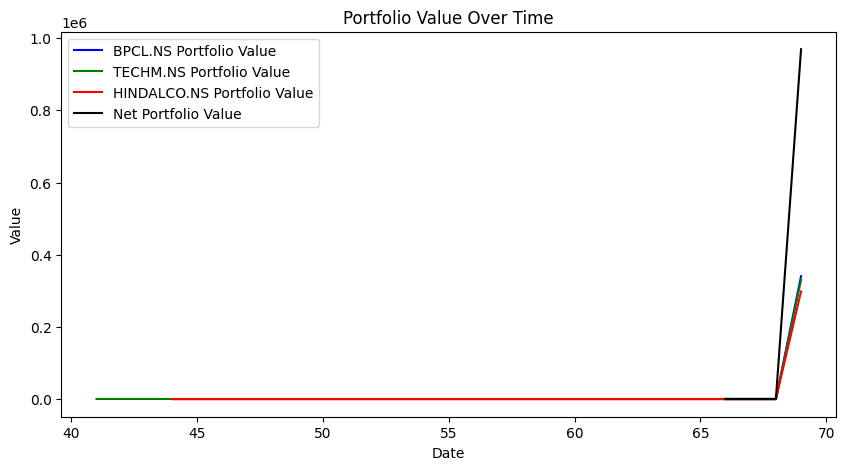

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(daily_df1['portfolio_value'], label=f'{stocks[0]} Portfolio Value', color='blue')
plt.plot(daily_df2['portfolio_value'], label=f'{stocks[1]} Portfolio Value', color='green')
plt.plot(daily_df3['portfolio_value'], label=f'{stocks[2]} Portfolio Value', color='red')
plt.plot(net_portfolio_value, label='Net Portfolio Value', color='black')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [79]:
#print metrics
metrics1_df = pd.DataFrame({
    f'{stocks[0]} Metric': metric1.keys(),
    'Metrics': metric1.values()
})
metrics2_df = pd.DataFrame({
    f'{stocks[1]} Metric': metric2.keys(),
    'Metrics': metric2.values()
})
metrics3_df = pd.DataFrame({
    f'{stocks[2]} Metric': metric3.keys(),
    'Metrics': metric3.values()
})

print(metrics1_df)
print('\n',metrics2_df)
print('\n',metrics3_df)



        BPCL.NS Metric   Metrics
0         Net Profit % -1.065469
1       Gross Profit %  0.000000
2         Total Trades  1.000000
3                 Wins  0.000000
4               Losses  1.000000
5             Win Rate  0.000000
6   Avg Trade Duration  3.000000
7   Max Trade Duration  3.000000
8         Max Drawdown  0.000000
9         Avg Drawdown  0.000000
10             Max Dip  0.000000
11             Avg Dip  0.000000
12        Sharpe Ratio       NaN
13       Sortino Ratio       NaN

        TECHM.NS Metric     Metrics
0         Net Profit %    0.384496
1       Gross Profit %    0.384496
2         Total Trades    1.000000
3                 Wins    1.000000
4               Losses    0.000000
5             Win Rate  100.000000
6   Avg Trade Duration   28.000000
7   Max Trade Duration   28.000000
8         Max Drawdown    0.000000
9         Avg Drawdown    0.000000
10             Max Dip    0.000000
11             Avg Dip    0.000000
12        Sharpe Ratio         NaN
13       Sort